# Computational-based 


In [14]:
# Load the Data

import pandas as pd


malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})


# clean_data = clean_data.drop(['ID','Subjectivity', 'Sentiment Polarity', 'Sarcasm', 'Irony', 'Negation'], axis=1)

clean_data.info()
clean_data.head()
clean_data.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 5072
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  1114 non-null   int64 
 1   Text                1114 non-null   object
 2   Subjectivity        1114 non-null   int64 
 3   Sentiment Polarity  1114 non-null   object
 4   Emotion             1114 non-null   object
 5   Sarcasm             1114 non-null   int64 
 6   Irony               1114 non-null   int64 
 7   Negation            1114 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 78.3+ KB


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
5068,20200659,"Wow growing together, so I will get a 17 black...",1,positive,disgust,0,1,0
5069,20200660,Equal pay for equal work to be introduced in t...,1,positive,anticipation,0,0,1
5070,20200661,No cash when worth more then 10000?. Use offsh...,1,negative,anticipation,0,1,0
5071,20200662,"Budget 2020 reactions: Some say it’s good, oth...",1,negative,anger,0,0,0
5072,20200663,"Budget 2020 reactions: Some say it’s good, oth...",1,neutral,sadness,0,0,0


In [15]:
# Handle text processing and tokenisation:

import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer, AutoTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Raw_Text'] = processed_data['Text']

processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
tokenizer.model_max_length = 100
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

processed_data.head()

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,Raw_Text,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,Great BUDGET . Even cigarettes were not touche...,"[great, budget, even, ci, ##gare, ##tte, touch...","[101, 11838, 21455, 12818, 11200, 46511, 11993...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,I haven't exactly scanned the budget throughou...,"[exactly, sc, ##anne, ##d, budget, throughout,...","[101, 56938, 16427, 31570, 10163, 21455, 15410...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,There’s already smoking cessation programs for...,"[already, smoking, ces, ##sation, program, peo...","[101, 18874, 67503, 12139, 22337, 11660, 11227...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,So should alcohol and fuel for private vehicle...,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 31329, 26150, 13742, 23247, 47651, 22389...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,Practical? You should say that in a third worl...,"[practical, say, third, world, country, suppos...","[101, 37872, 16497, 12047, 10228, 11913, 54838...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [16]:
# Count Punctuation

import re
import pandas as pd

def count_punctuation(text, tokens):
    exclamation_count = len(re.findall(r'!', text))
    question_count = len(re.findall(r'\?', text))
    ellipsis_count = len(re.findall(r'\.\.\.', text))
    comma_count = len(re.findall(r',', text))
    period_count = len(re.findall(r'\. ', text))
    token_count = len(tokens)
    if token_count == 0:
        token_count = 1
    return pd.Series({
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'ellipsis_count': ellipsis_count,
        'comma_count': comma_count,
        'period_count': period_count,
        'exclamation_score': exclamation_count / token_count,
        'question_score': question_count / token_count,
        'ellipsis_score': ellipsis_count / token_count,
        'comma_score': comma_count / token_count,
        'period_score': period_count / token_count
    })

processed_data = processed_data.join(
    processed_data.apply(lambda row: count_punctuation(row['Raw_Text'], row['tokens']), axis=1)
)
    
print(processed_data)

            ID                                               Text  \
0     20180001  great budget even cigarette touched great work...   
1     20180002  exactly scanned budget throughout earth make i...   
2     20180003  already smoking cessation program people want ...   
3     20180004  alcohol fuel private vehicle raising tax cigar...   
4     20180005  practical say third world country supposed eur...   
...        ...                                                ...   
5068  20200659              wow growing together get black budget   
5069  20200660  equal pay equal work introduced private sector...   
5070  20200661                    cash worth use offshore account   
5071  20200662  budget reaction say good others say bad earnes...   
5072  20200663  budget reaction say good others say bad happen...   

      Subjectivity Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0                1           positive         trust        0      0         1   
1        

In [17]:
#getting Polarity. 
from tqdm import tqdm
from transformers import pipeline, AutoModelForSequenceClassification

# Load sentiment analysis pipeline
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def get_sentiment(tokens):
    total_score = 0
    result = sentiment_analyzer(tokens)
    if len(result) == 0:
        return 0.0
    for r in result:
        total_score += r['score']
    return total_score / len(result)

processed_data['polarity_score'] = processed_data['tokens'].apply(get_sentiment)

print(processed_data[['Text','Sentiment Polarity','polarity_score']].head())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                                Text Sentiment Polarity  \
0  great budget even cigarette touched great work...           positive   
1  exactly scanned budget throughout earth make i...           negative   
2  already smoking cessation program people want ...            neutral   
3  alcohol fuel private vehicle raising tax cigar...           negative   
4  practical say third world country supposed eur...           negative   

   polarity_score  
0        0.344246  
1        0.355173  
2        0.327859  
3        0.337148  
4        0.353488  


In [29]:
#Subjectivity

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification
import torch
import logging

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")
bert_model = BertModel.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and convert to BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

X = get_bert_embeddings(processed_data['Text'])
y = processed_data['Subjectivity']

# Train SVM classifier
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
clf.fit(X, y)

# Get the decision function values or probabilities
subjectivity_probabilities = clf.predict_proba(X)

# Assuming binary classification, we take the probability of the positive class (index 1)
processed_data['Subjectivity Score'] = subjectivity_probabilities[:, 1]

print(processed_data[['Text', 'Subjectivity', 'Subjectivity Score']].head())
print(processed_data[['Text', 'Subjectivity', 'Subjectivity Score']].tail())

# subjectivity_scores = clf.decision_function(X)
# processed_data['Subjectivity Score'] = subjectivity_scores
# print(processed_data[['Text', 'Subjectivity', 'Subjectivity Score']].head())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                                Text  Subjectivity  \
0  great budget even cigarette touched great work...             1   
1  exactly scanned budget throughout earth make i...             1   
2  already smoking cessation program people want ...             1   
3  alcohol fuel private vehicle raising tax cigar...             1   
4  practical say third world country supposed eur...             1   

   Subjectivity Score  
0            0.995394  
1            0.999982  
2            0.999993  
3            0.999987  
4            0.996932  
                                                   Text  Subjectivity  \
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1 

In [21]:
# Sarcasm detection using BERT and LSTM
import torch
import torch.nn as nn


class SarcasmLSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, num_layers):
        super(SarcasmLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        with torch.no_grad():
            bert_output = self.bert(**inputs).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        logits = self.fc(lstm_output[:, -1, :])
        return self.sigmoid(logits)

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")
bert_model = BertModel.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize the LSTM model
sarcasm_model = SarcasmLSTM(bert_model, hidden_dim=256, output_dim=1, num_layers=2)

# Tokenize and predict sarcasm for the entire dataset
inputs = tokenizer(processed_data['Text'].tolist(), return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    sarcasm_prob = sarcasm_model(inputs).numpy()

processed_data['Sarcasm Score'] = sarcasm_prob.flatten()  # Keep the raw probability

print(processed_data[['Text', 'Sarcasm', 'Sarcasm Score']].head())

                                                Text  Sarcasm  Sarcasm Score
0  great budget even cigarette touched great work...        0       0.492185
1  exactly scanned budget throughout earth make i...        0       0.489849
2  already smoking cessation program people want ...        0       0.491427
3  alcohol fuel private vehicle raising tax cigar...        0       0.494432
4  practical say third world country supposed eur...        0       0.490008


In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import pandas as pd

# Load the fine-tuned RoBERTa model and tokenizer for irony detection
tokenizer = AutoTokenizer.from_pretrained("vikram71198/roberta-base-finetuned-irony")
roberta_model = AutoModelForSequenceClassification.from_pretrained("vikram71198/roberta-base-finetuned-irony")

# Function to get predictions directly from the RoBERTa model
def detect_irony(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    
    # Convert logits to probabilities
    probabilities = torch.softmax(outputs.logits, dim=-1)
    
    # The model returns a probability for each class (ironic or not ironic)
    # Assuming binary classification (ironic vs. not ironic), we take the probability for the 'ironic' class
    irony_scores = probabilities[:, 1].numpy()  # Index 1 is usually for the positive class
    
    return irony_scores

# Assume processed_data is your DataFrame containing a 'Text' column
# Get irony scores for each text in the DataFrame
processed_data['Irony Score'] = detect_irony(processed_data['Text'])

# Print the results
print(processed_data[['Text', 'Irony Score']].head())

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

                                                Text  Irony Score
0  great budget even cigarette touched great work...     0.177694
1  exactly scanned budget throughout earth make i...     0.620364
2  already smoking cessation program people want ...     0.453496
3  alcohol fuel private vehicle raising tax cigar...     0.251844
4  practical say third world country supposed eur...     0.657175


In [23]:
# Negation detection
import torch
import torch
from TorchCRF import CRF
from transformers import AutoModelForTokenClassification


class LSTM_CRF(nn.Module):
    def __init__(self, bert_model, hidden_dim, tagset_size):
        super(LSTM_CRF, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, inputs):
        with torch.no_grad():
            bert_output = self.bert(**inputs).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        emissions = self.hidden2tag(lstm_output)
        return emissions

    def predict(self, inputs):
        emissions = self(inputs)
        return self.crf.decode(emissions), emissions

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("shoubhikc/negation_bert")
bert_model = BertModel.from_pretrained("shoubhikc/negation_bert")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize the LSTM-CRF model
negation_model = LSTM_CRF(bert_model, hidden_dim=128, tagset_size=3)  # Assume 3 tags (e.g., "O", "NEG", "POS")

# Tokenize and predict negation for the entire dataset
inputs = tokenizer(processed_data['Text'].tolist(), return_tensors='pt', padding=True, truncation=True)

negation_tags, negation_scores = negation_model.predict(inputs)

# Extract the highest score for negation tag for each sentence
processed_data['Negation Score'] = [torch.max(score[:, 1]).item() for score in negation_scores]  # Assuming index 1 is the "NEG" tag

print(processed_data[['Text', 'Negation', 'Negation Score']].head())


tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

                                                Text  Negation  Negation Score
0  great budget even cigarette touched great work...         1        0.171041
1  exactly scanned budget throughout earth make i...         1        0.172005
2  already smoking cessation program people want ...         0        0.129057
3  alcohol fuel private vehicle raising tax cigar...         0        0.012175
4  practical say third world country supposed eur...         1        0.149648


In [24]:
from afinn import Afinn

afinn = Afinn()
processed_data['afinn_score'] = processed_data['Raw_Text'].apply(lambda x: afinn.score(x))

print(processed_data)

            ID                                               Text  \
0     20180001  great budget even cigarette touched great work...   
1     20180002  exactly scanned budget throughout earth make i...   
2     20180003  already smoking cessation program people want ...   
3     20180004  alcohol fuel private vehicle raising tax cigar...   
4     20180005  practical say third world country supposed eur...   
...        ...                                                ...   
5068  20200659              wow growing together get black budget   
5069  20200660  equal pay equal work introduced private sector...   
5070  20200661                    cash worth use offshore account   
5071  20200662  budget reaction say good others say bad earnes...   
5072  20200663  budget reaction say good others say bad happen...   

      Subjectivity Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0                1           positive         trust        0      0         1   
1        

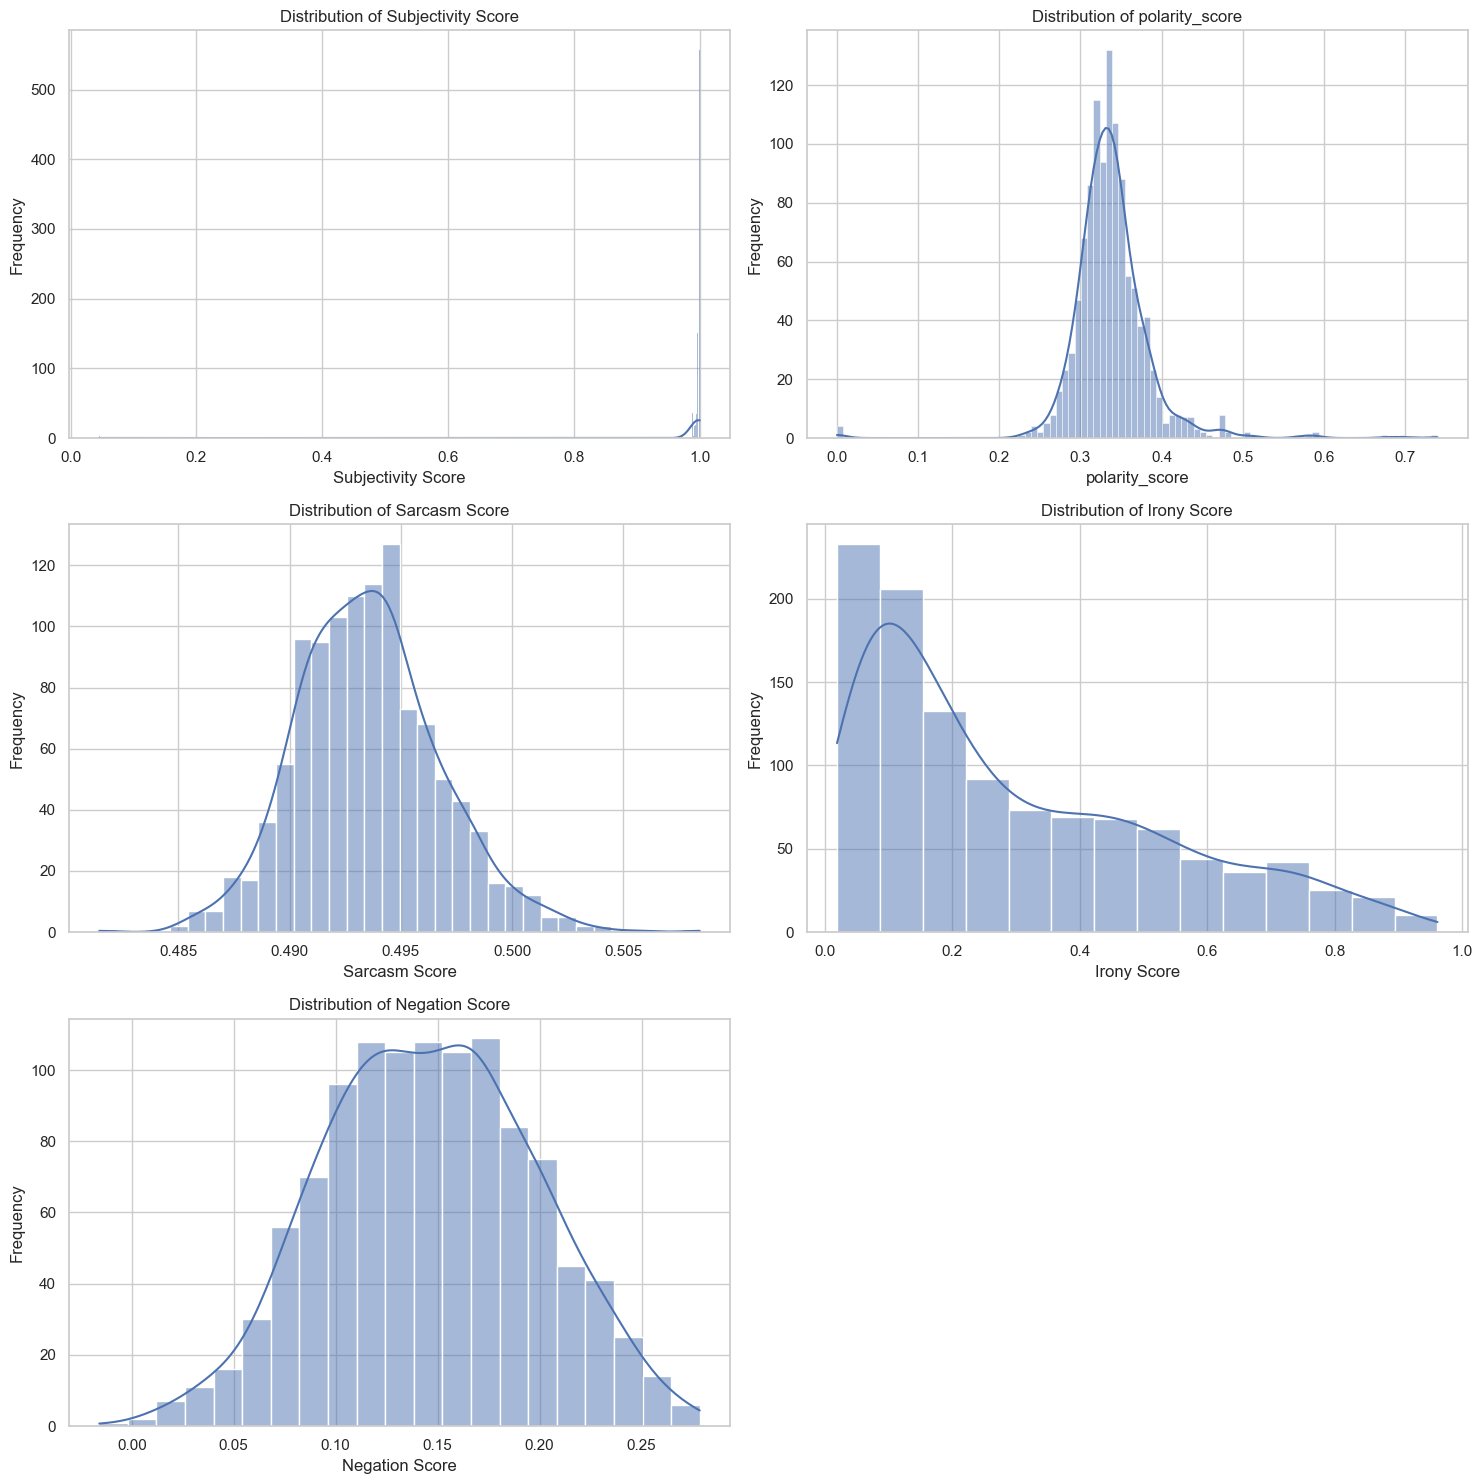

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn
sns.set(style="whitegrid")

columns_to_plot = ['Subjectivity Score', 'polarity_score', 'Sarcasm Score', 'Irony Score', 'Negation Score']

# Set up the plot grid: 2 columns per row
num_cols = 2
num_rows = (len(columns_to_plot) + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(columns_to_plot):
    sns.histplot(processed_data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots (in case of an odd number of plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show plot
plt.show()

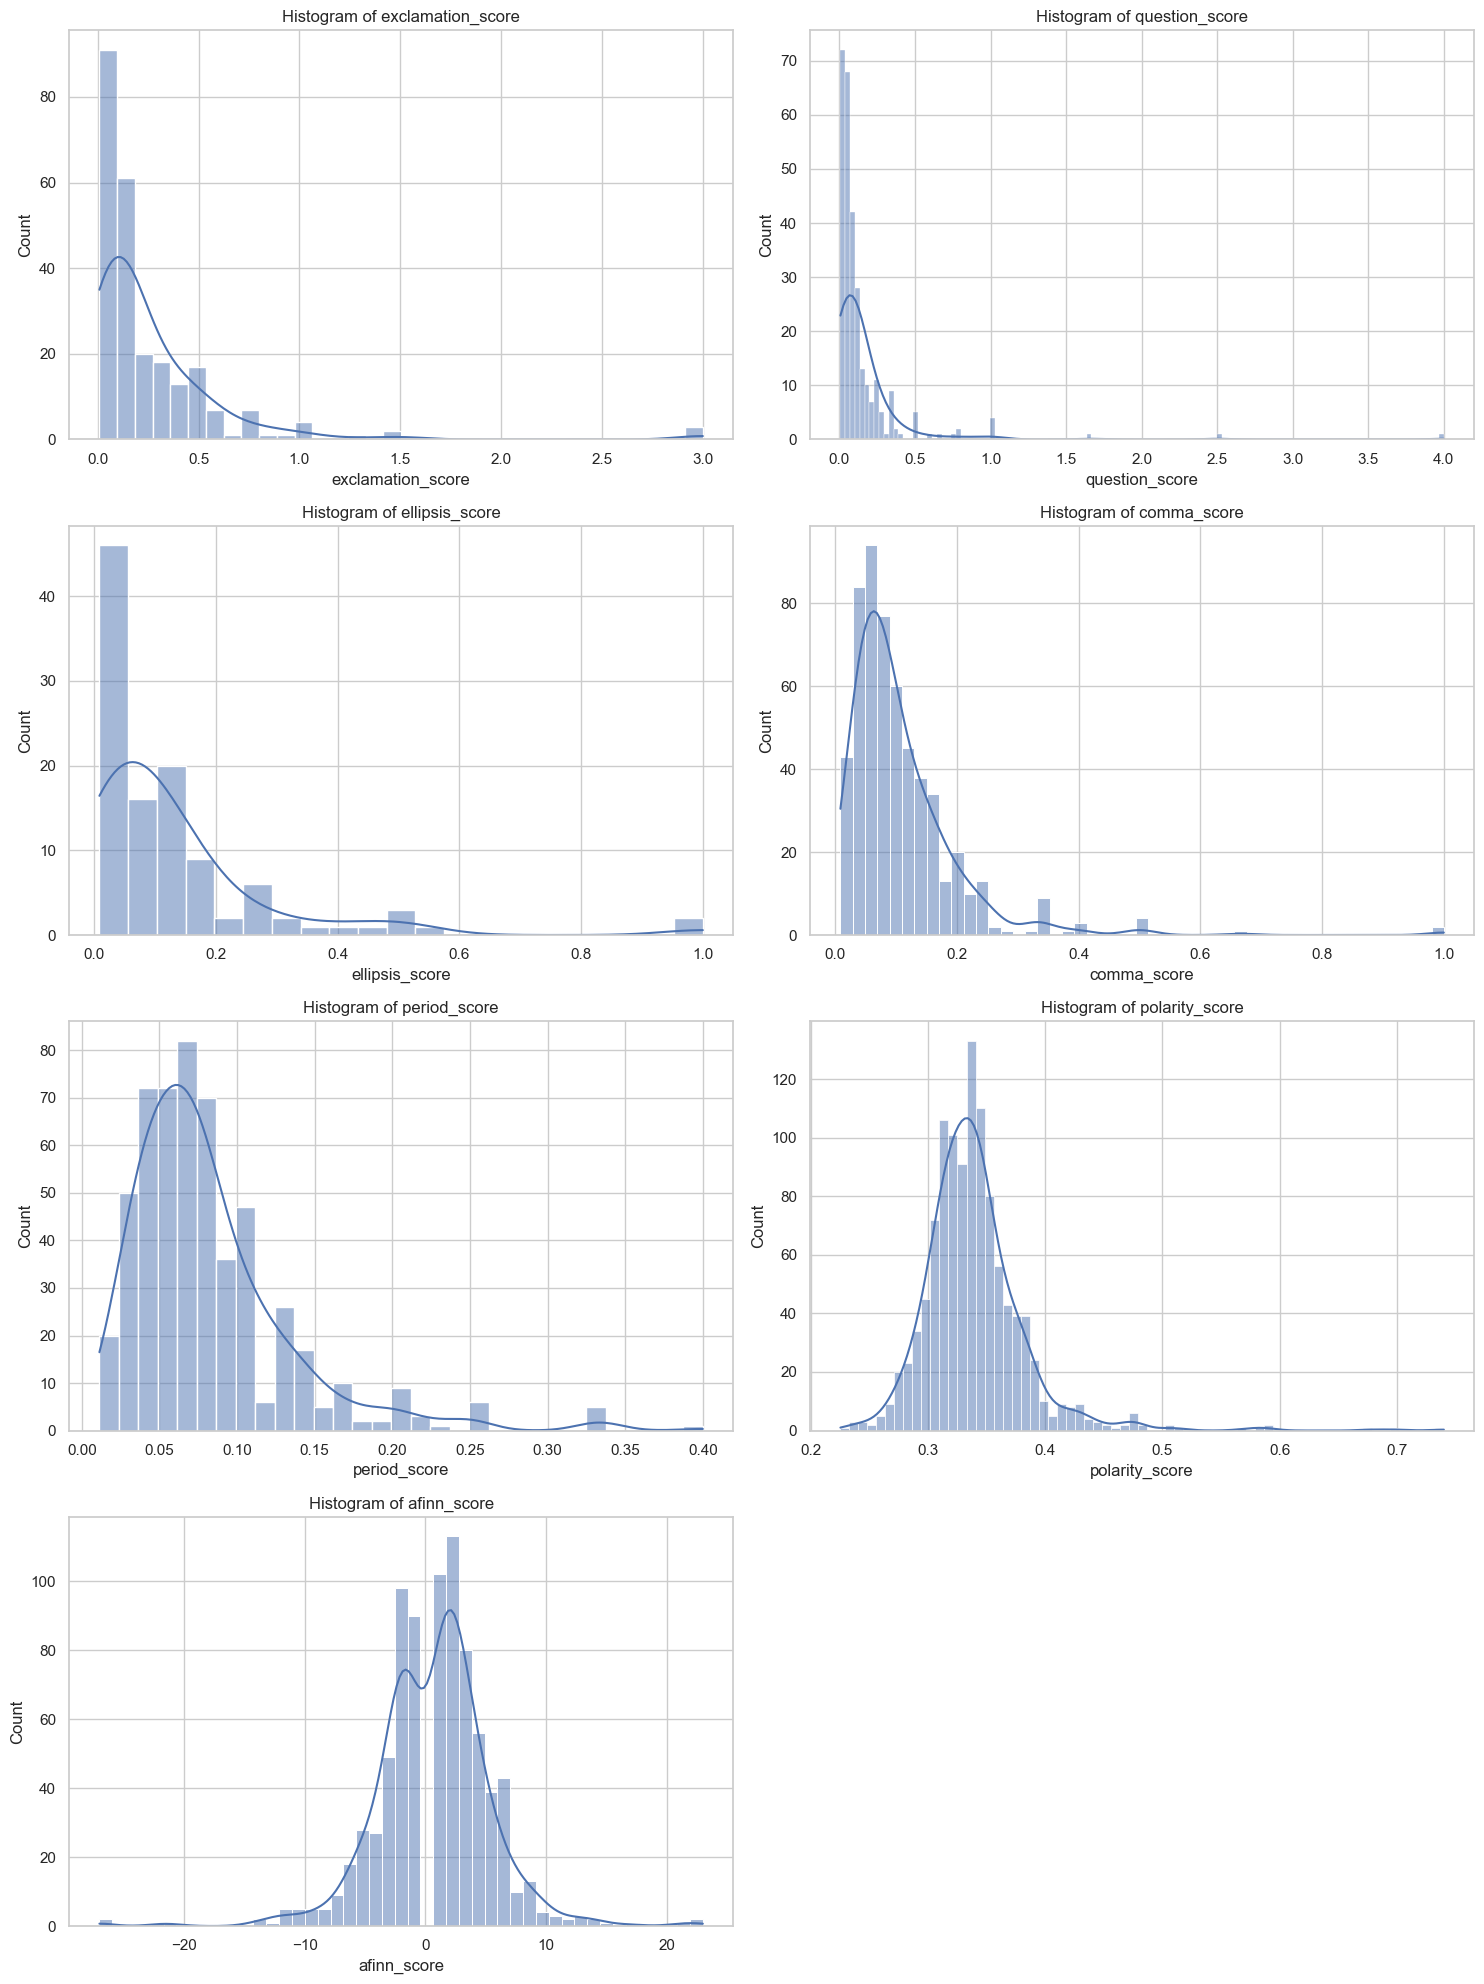

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

score_columns = [col for col in processed_data.columns if col.endswith('_score')]

# Step 2: Set up the grid layout
num_columns = 2  # Number of plots per row
num_plots = len(score_columns)
num_rows = (num_plots + num_columns - 1) // num_columns  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Step 3: Plot each histogram
for i, col in enumerate(score_columns):
    row = i // num_columns
    col_index = i % num_columns
    non_zero_data = processed_data[col][processed_data[col] != 0]
    #use processed_data[col] instead of non_zero_data
    sns.histplot(non_zero_data, kde=True, ax=axes[row, col_index])
    axes[row, col_index].set_title(f'Histogram of {col}')

# If the number of plots is odd, remove the empty subplot
if num_plots % num_columns != 0:
    fig.delaxes(axes[num_rows-1, num_columns-1])

plt.tight_layout()
plt.show()

In [31]:
processed_data.to_csv('processed_data_V2.csv', index=False)

# FUZZY LOGIC SECTION

In [18]:
# DO fuzzy logic here.

import skfuzzy as fuzz

exclamation_range = np.arange(processed_data['exclamation_score'].min(), processed_data['exclamation_score'].max(), 0.1) 
mean_low_exclamation = processed_data['exclamation_score'].mean() - processed_data['exclamation_score'].std()
mean_high_exclamation = processed_data['exclamation_score'].mean() + processed_data['exclamation_score'].std()
std_dev_exclamation = processed_data['exclamation_score'].std()
low_exclamation = fuzz.gaussmf(exclamation_range, mean_low_exclamation, std_dev_exclamation)
high_exclamation = fuzz.gaussmf(exclamation_range, mean_high_exclamation, std_dev_exclamation)

question_range = np.arange(processed_data['question_score'].min(), processed_data['question_score'].max(), 0.1) 
mean_low_question = processed_data['question_score'].mean() - processed_data['question_score'].std()
mean_high_question = processed_data['question_score'].mean() + processed_data['question_score'].std()
std_dev_question = processed_data['question_score'].std()
low_question = fuzz.gaussmf(question_range, mean_low_question, std_dev_question)
high_question = fuzz.gaussmf(question_range, mean_high_question, std_dev_question)

ellipsis_range = np.arange(processed_data['ellipsis_score'].min(), processed_data['ellipsis_score'].max(), 0.1) 
mean_low_ellipsis = processed_data['ellipsis_score'].mean() - processed_data['ellipsis_score'].std()
mean_high_ellipsis = processed_data['ellipsis_score'].mean() + processed_data['ellipsis_score'].std()
std_dev_ellipsis = processed_data['ellipsis_score'].std()
low_ellipsis = fuzz.gaussmf(ellipsis_range, mean_low_ellipsis, std_dev_ellipsis)
high_ellipsis = fuzz.gaussmf(ellipsis_range, mean_high_ellipsis, std_dev_ellipsis)

comma_range = np.arange(processed_data['comma_score'].min(), processed_data['comma_score'].max(), 0.1) 
mean_low_comma = processed_data['comma_score'].mean() - processed_data['comma_score'].std()
mean_high_comma = processed_data['comma_score'].mean() + processed_data['comma_score'].std()
std_dev_comma = processed_data['comma_score'].std()
low_comma = fuzz.gaussmf(comma_range, mean_low_comma, std_dev_comma)
high_comma = fuzz.gaussmf(comma_range, mean_high_comma, std_dev_comma)

period_range = np.arange(processed_data['period_score'].min(), processed_data['period_score'].max(), 0.1) 
mean_low_period = processed_data['period_score'].mean() - processed_data['period_score'].std()
mean_high_period = processed_data['period_score'].mean() + processed_data['period_score'].std()
std_dev_period = processed_data['period_score'].std()
low_period = fuzz.gaussmf(period_range, mean_low_period, std_dev_period)
high_period = fuzz.gaussmf(period_range, mean_high_period, std_dev_period)

subjective_range = np.arange(processed_data['Subjectivity Score'].min(), processed_data['Subjectivity Score'].max(), 0.1) 
mean_low_subjective = processed_data['Subjectivity Score'].mean() - processed_data['Subjectivity Score'].std()
mean_high_subjective = processed_data['Subjectivity Score'].mean() + processed_data['Subjectivity Score'].std()
std_dev_subjective = processed_data['Subjectivity Score'].std()
low_subjective = fuzz.gaussmf(subjective_range, mean_low_subjective, std_dev_subjective)
high_subjective = fuzz.gaussmf(subjective_range, mean_high_subjective, std_dev_subjective)

polarity_range = np.arange(processed_data['polarity_score'].min(), processed_data['polarity_score'].max(), 0.1) 
mean_low_polarity = processed_data['polarity_score'].mean() - processed_data['polarity_score'].std()
mean_high_polarity = processed_data['polarity_score'].mean() + processed_data['polarity_score'].std()
std_dev_polarity = processed_data['polarity_score'].std()
low_polarity = fuzz.gaussmf(polarity_range, mean_low_polarity, std_dev_polarity)
high_polarity = fuzz.gaussmf(polarity_range, mean_high_polarity, std_dev_polarity)

afinn_range = np.arange(processed_data['afinn_score'].min(), processed_data['afinn_score'].max(), 0.1) 
mean_low_afinn = processed_data['afinn_score'].mean() - processed_data['afinn_score'].std()
mean_high_afinn = processed_data['afinn_score'].mean() + processed_data['afinn_score'].std()
std_dev_afinn = processed_data['afinn_score'].std()
low_afinn = fuzz.gaussmf(afinn_range, mean_low_afinn, std_dev_afinn)
high_afinn = fuzz.gaussmf(afinn_range, mean_high_afinn, std_dev_afinn)

negation_range = np.arange(processed_data['Negation Score'].min(), processed_data['Negation Score'].max(), 0.1) 
mean_low_negation = processed_data['Negation Score'].mean() - processed_data['Negation Score'].std()
mean_high_negation = processed_data['Negation Score'].mean() + processed_data['Negation Score'].std()
std_dev_negation = processed_data['Negation Score'].std()
low_negation = fuzz.gaussmf(negation_range, mean_low_negation, std_dev_negation)
high_negation = fuzz.gaussmf(negation_range, mean_high_negation, std_dev_negation)

sarcasm_range = np.arange(processed_data['Sarcasm Score'].min(), processed_data['Sarcasm Score'].max(), 0.1) 
mean_low_sarcasm = processed_data['Sarcasm Score'].mean() - processed_data['Sarcasm Score'].std()
mean_high_sarcasm = processed_data['Sarcasm Score'].mean() + processed_data['Sarcasm Score'].std()
std_dev_sarcasm = processed_data['Sarcasm Score'].std()
low_sarcasm = fuzz.gaussmf(negation_range, mean_low_negation, std_dev_negation)
high_sarcasm = fuzz.gaussmf(negation_range, mean_high_negation, std_dev_negation)

In [19]:
import skfuzzy.control as ctrl

import sys
sys.path.insert(0, './anfis_twmeggs/')
import anfis_twmeggs as anfis
from anfis import ANFIS


to_keep = ['exclamation_score', 'question_score', 'ellipsis_score', 'comma_score', 'period_score',
           'Subjectivity Score', 'polarity_score', 'afinn_score', 'Negation Score', 'Sarcasm Score']
fuzzy_data = processed_data[to_keep]

emotions = ['joy', 'sadness', 'trust', 'disgust', 'fear', 'anger', 'surprise', 'anticipation']

emotion = ctrl.Consequent(np.arange(0, 8, 1), 'emotion', defuzzify_method='centroid')
emotion.automf(8, names=emotions)

rule1 = ctrl.Rule(high_exclamation & high_polarity & low_negation, emotion['joy'])
rule2 = ctrl.Rule(low_exclamation & high_ellipsis & low_polarity, emotion['sadness'])

rule3 = ctrl.Rule(high_question & high_subjective & low_sarcasm, emotion['trust'])
rule4 = ctrl.Rule(low_exclamation & high_negation, emotion['disgust'])

rule5 = ctrl.Rule(high_exclamation & low_polarity & high_negation, emotion['fear'])
rule6 = ctrl.Rule(high_exclamation & high_comma & high_negation, emotion['anger'])

rule7 = ctrl.Rule(high_exclamation & high_question & low_negation, emotion['surprise'])
rule8 = ctrl.Rule(low_exclamation & high_ellipsis & high_subjective, emotion['anticipation'])

emotion_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)

X = fuzzy_data.values
Y = processed_data['Emotion'].values

# Initialize ANFIS model
anfis_model = ANFIS(X, Y, n_inputs=X.shape[1], n_rules=8)  # Adjust n_rules as needed

# Train the model
anfis_model.train(epochs=100)

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [20]:
import skfuzzy as fuzz
import numpy as np

# Define the scores and their corresponding keys in processed_data
score_keys = [
    'exclamation_score', 'question_score', 'ellipsis_score', 'comma_score', 'period_score',
    'Subjectivity Score', 'polarity_score', 'afinn_score', 'Negation Score', 'Sarcasm Score'
]

# Configuration for variable membership functions
# Each key has a list of tuples where each tuple defines a membership function:
# (name, mean_offset, std_dev_multiplier)
membership_configs = {
    'exclamation_score': [('low', -1, 1), ('high', 1, 1)],
    'question_score': [('low', -1, 1), ('high', 1, 1)],
    'ellipsis_score': [('low', -1, 1), ('high', 1, 1)],
    'comma_score': [('low', -1, 1), ('high', 1, 1)],
    'period_score': [('low', -1, 1), ('high', 1, 1)],
    'Subjectivity Score': [('low', -1, 1), ('medium', 0, 1), ('high', 1, 1)],
    'polarity_score': [('negative', -1, 1), ('neutral', 0, 1), ('positive', 1, 1)],
    'afinn_score': [
        ('very_negative', -2, 1),  # Mean offset by -2 standard deviations for very negative
        ('negative', -1, 1),       # Mean offset by -1 standard deviation for negative
        ('neutral', 0, 1),         # No offset for neutral
        ('positive', 1, 1),        # Mean offset by +1 standard deviation for positive
        ('very_positive', 2, 1)    # Mean offset by +2 standard deviations for very positive
    ],
    'Negation Score': [('low', -1, 1), ('high', 1, 1)],
    'Sarcasm Score': [('low', -1, 1), ('medium', 0, 1), ('high', 1, 1)],
}

# Initialize a dictionary to store the Antecedents
fuzzy_variables = {}

# Iterate over each score type and create the fuzzy variables with variable memberships
for score_key in score_keys:
    # Define the range for each score type
    score_range = np.arange(processed_data[score_key].min(), processed_data[score_key].max(), 0.1)
    
    # Create the Antecedent for this score type
    fuzzy_variables[score_key] = fuzz.control.Antecedent(score_range, score_key)
    
    # Define membership functions based on the configuration
    for name, mean_offset, std_dev_multiplier in membership_configs[score_key]:
        mean = processed_data[score_key].mean() + mean_offset * processed_data[score_key].std()
        std_dev = std_dev_multiplier * processed_data[score_key].std()
        fuzzy_variables[score_key][name] = fuzz.gaussmf(score_range, mean, std_dev)

# Example of accessing the fuzzy variables for 'afinn_score'
print(fuzzy_variables)


{'exclamation_score': Antecedent: exclamation_score, 'question_score': Antecedent: question_score, 'ellipsis_score': Antecedent: ellipsis_score, 'comma_score': Antecedent: comma_score, 'period_score': Antecedent: period_score, 'Subjectivity Score': Antecedent: Subjectivity Score, 'polarity_score': Antecedent: polarity_score, 'afinn_score': Antecedent: afinn_score, 'Negation Score': Antecedent: Negation Score, 'Sarcasm Score': Antecedent: Sarcasm Score}


/var/folders/lx/s6mpvqt1305650xxj6d7yfj80000gn/T/ipykernel_64231/2807628771.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


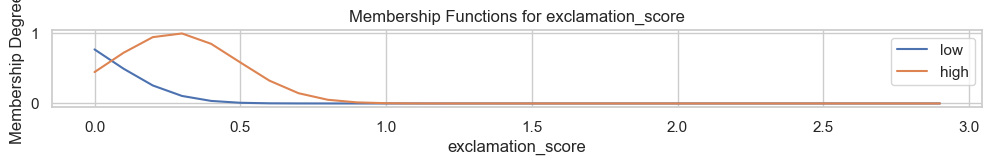

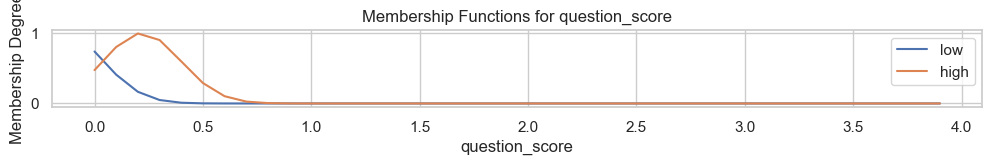

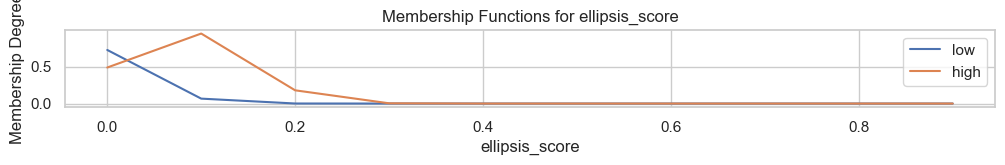

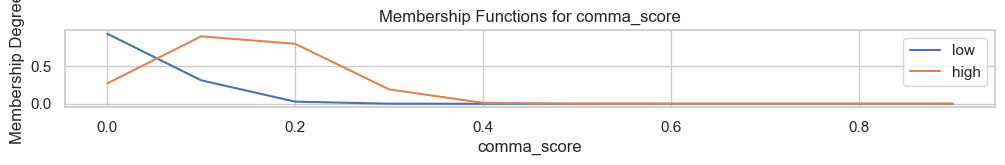

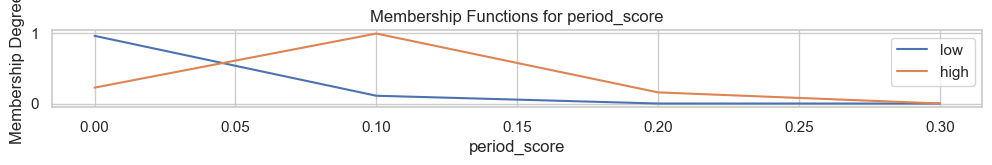

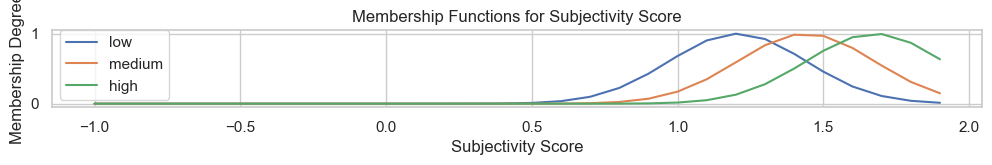

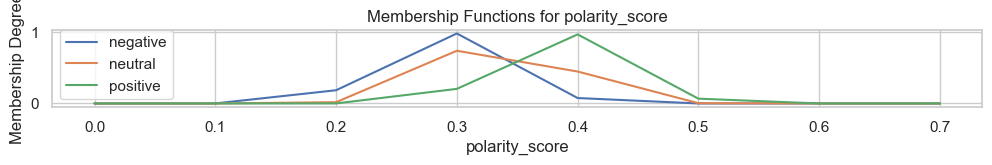

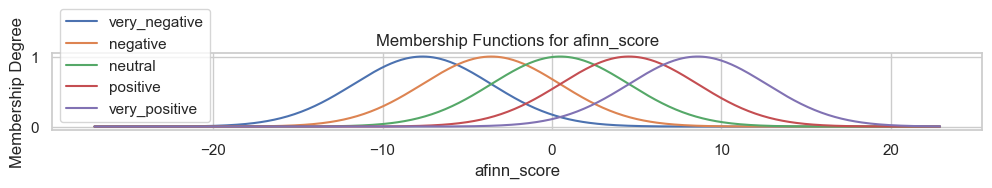

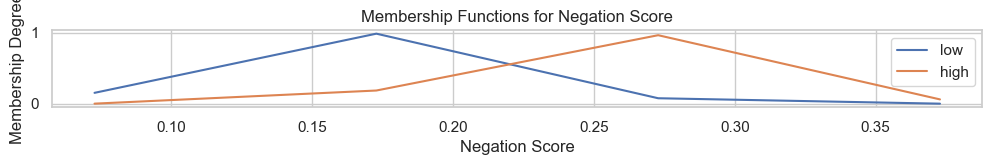

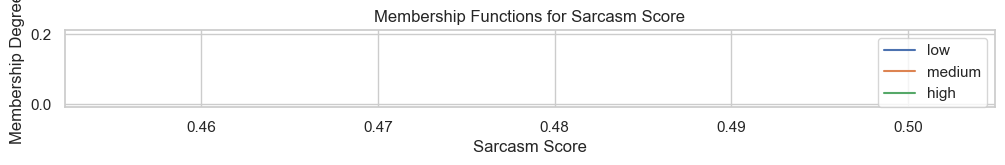

In [21]:
import matplotlib.pyplot as plt

# Iterate over each score key and its fuzzy variable
for score_key, fuzzy_var in fuzzy_variables.items():
    plt.figure(figsize=(12, 1))
    
    # Plot each membership function for the current score key
    for mf_name in fuzzy_var.terms:
        plt.plot(fuzzy_var.universe, fuzzy_var[mf_name].mf, label=mf_name)
    
    plt.title(f'Membership Functions for {score_key}')
    plt.xlabel(score_key)
    plt.ylabel('Membership Degree')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
import skfuzzy.control as ctrl

# Assume fuzzy_variables have been defined as shown previously

# Define the consequent variable 'emotion' with the same structure as before
emotions = ['joy', 'sadness', 'trust', 'disgust', 'fear', 'anger', 'surprise', 'anticipation']
emotion = ctrl.Consequent(np.arange(0, 8, 1), 'emotion', defuzzify_method='centroid')
emotion.automf(8, names=emotions)

# Define your rules using the fuzzy_variables
rule1 = ctrl.Rule(
    fuzzy_variables['exclamation_score']['high'] & 
    fuzzy_variables['polarity_score']['positive'] & 
    fuzzy_variables['Negation Score']['low'], 
    emotion['joy']
)

rule2 = ctrl.Rule(
    fuzzy_variables['exclamation_score']['low'] & 
    fuzzy_variables['ellipsis_score']['high'] & 
    fuzzy_variables['polarity_score']['negative'], 
    emotion['sadness']
)

rule3 = ctrl.Rule(
    fuzzy_variables['question_score']['high'] & 
    fuzzy_variables['Subjectivity Score']['high'] & 
    fuzzy_variables['Sarcasm Score']['low'], 
    emotion['trust']
)

rule4 = ctrl.Rule(
    fuzzy_variables['exclamation_score']['low'] & 
    fuzzy_variables['Negation Score']['high'], 
    emotion['disgust']
)

rule5 = ctrl.Rule(
    fuzzy_variables['exclamation_score']['high'] & 
    fuzzy_variables['polarity_score']['negative'] & 
    fuzzy_variables['Negation Score']['high'], 
    emotion['fear']
)

rule6 = ctrl.Rule(
    fuzzy_variables['exclamation_score']['high'] & 
    fuzzy_variables['comma_score']['high'] & 
    fuzzy_variables['Negation Score']['high'], 
    emotion['anger']
)

rule7 = ctrl.Rule(
    fuzzy_variables['exclamation_score']['high'] & 
    fuzzy_variables['question_score']['high'] & 
    fuzzy_variables['Negation Score']['low'], 
    emotion['surprise']
)

rule8 = ctrl.Rule(
    fuzzy_variables['exclamation_score']['low'] & 
    fuzzy_variables['ellipsis_score']['high'] & 
    fuzzy_variables['Subjectivity Score']['high'], 
    emotion['anticipation']
)

# Create the control system and simulation
emotion_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
emotion_sim = ctrl.ControlSystemSimulation(emotion_ctrl)

# Now you can proceed with the ANFIS model as before
X = fuzzy_data.values
Y = processed_data['Emotion'].values

# # Initialize ANFIS model
# anfis_model = ANFIS(X, Y, fuzzy_variables) # Adjust n_rules as needed

# # Train the model
# anfis_model.train(epochs=100)

In [23]:
mf = [
    [['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}]], # exclamation_score
    [['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}]], # question_score
    [['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}]], # ellipsis_score
    [['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}]], # comma_score
    [['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}]], # period_score
    [['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':0,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}]], # Subjectivity Score
    [['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':0,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}]], # polarity_score
    [['gaussmf',{'mean':-2,'sigma':1}],
     ['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':0,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}],
     ['gaussmf',{'mean':2,'sigma':1}]], # afinn_score
    [['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}]], # Negation Score
    [['gaussmf',{'mean':-1,'sigma':1}],
     ['gaussmf',{'mean':0,'sigma':1}],
     ['gaussmf',{'mean':1,'sigma':1}]]] #Sarcasm Score

mfc = anfis.membershipfunction.MemFuncs(mf)

anf = ANFIS(X, y, mfc)

anf.trainHybridJangOffLine(epochs=2)

: 

In [ ]:
anf.plotErrors()


: 

In [ ]:
anf.memFuncs

: 

In [ ]:
# print 'linguistic variables' in our membership functions
# since we have defined 4 MF for each variable we will have 0,1,2,3 as values
# for example, they could be low=0, medium=1, high=2, very high=3
print('Linguistic variables:',anf.memFuncsByVariable)

# print rules order
# this is all the possible combinations of rules
# e.g., [2,1] = a activates linguistic variable 2, b activates linguistic value 1 
print('Combinations:', anf.rules)

# print consequents
print('Consequents:', anf.consequents)
print('# of consenquents:',len(anf.consequents))

: 

In [ ]:
anf.plotResults()


: 

In [ ]:

processed_data.describe()

: 